# Credit Card Fraud Detection
- Anonymized credit card transactions labeled as fraudulent or genuine
**Context**
- It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Content**
- The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

- It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

- Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.


## Import Data

### Import data and check missing values

- Import libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

- Import file and preview

In [23]:
crecard = pd.read_csv("./data/creditcard.csv")
crecard.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


- T-Test fraud outside outliers

In [24]:
from scipy.stats import ttest_ind

# Xác định outliers cho các biến V1-V28 (theo quy tắc 1.5*IQR)
outlier_mask = np.zeros(len(crecard), dtype=bool)
for col in [f'V{i}' for i in range(1, 29)]:
    Q1 = crecard[col].quantile(0.25)
    Q3 = crecard[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_mask |= (crecard[col] < lower) | (crecard[col] > upper)

# Tính tỉ lệ gian lận ở ngoài outliers và không phải outliers
fraud_rate_outliers = crecard.loc[outlier_mask, 'Class']
fraud_rate_non_outliers = crecard.loc[~outlier_mask, 'Class']

# Thực hiện T-Test
t_stat, p_value = ttest_ind(fraud_rate_outliers, fraud_rate_non_outliers, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Tỉ lệ gian lận ngoài outliers: {fraud_rate_outliers.mean():.4%}")
print(f"Tỉ lệ gian lận không phải outliers: {fraud_rate_non_outliers.mean():.4%}")

T-statistic: 21.0892
P-value: 1.4462e-98
Tỉ lệ gian lận ngoài outliers: 0.3708%
Tỉ lệ gian lận không phải outliers: 0.0096%


In [25]:
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu

fraud = crecard[crecard['Class'] == 1]['Amount']
normal = crecard[crecard['Class'] == 0]['Amount']

# Kiểm tra sự khác biệt phân phối Amount giữa hai nhóm bằng kiểm định Mann-Whitney U (không giả định phân phối chuẩn)

stat, p_mwu = mannwhitneyu(fraud, normal, alternative='two-sided')
print(f"Kết quả kiểm định Mann-Whitney U: statistic={stat:.2f}, p-value={p_mwu:.4e}")

Kết quả kiểm định Mann-Whitney U: statistic=61833399.00, p-value=8.5785e-06


In [26]:
bins = [0, 50, 100, 150, 200, 500, 1000, crecard['Amount'].max()+1]
labels = ['0-50', '50-100', '100-150', '150-200', '200-500', '500-1000', '>1000']
crecard['Amount_bin'] = pd.cut(crecard['Amount'], bins=bins, labels=labels, right=False)

fraud_rate_by_bin = crecard.groupby('Amount_bin')['Class'].mean()
count_by_bin = crecard.groupby('Amount_bin')['Class'].count()
fraud_count_by_bin = crecard.groupby('Amount_bin')['Class'].sum()

result = pd.DataFrame({
    'Total_Transactions': count_by_bin,
    'Fraud_Transactions': fraud_count_by_bin,
    'Fraud_Rate': fraud_rate_by_bin
})

print(result)

            Total_Transactions  Fraud_Transactions  Fraud_Rate
Amount_bin                                                    
0-50                    189704                 305    0.001608
50-100                   37718                  57    0.001511
100-150                  17471                  31    0.001774
150-200                  10599                  14    0.001321
200-500                  19823                  50    0.002522
500-1000                  6423                  26    0.004048
>1000                     3069                   9    0.002933


C:\Users\ducho\AppData\Local\Temp\ipykernel_11428\872610157.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = crecard.groupby('Amount_bin')['Class'].mean()
C:\Users\ducho\AppData\Local\Temp\ipykernel_11428\872610157.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_by_bin = crecard.groupby('Amount_bin')['Class'].count()
C:\Users\ducho\AppData\Local\Temp\ipykernel_11428\872610157.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

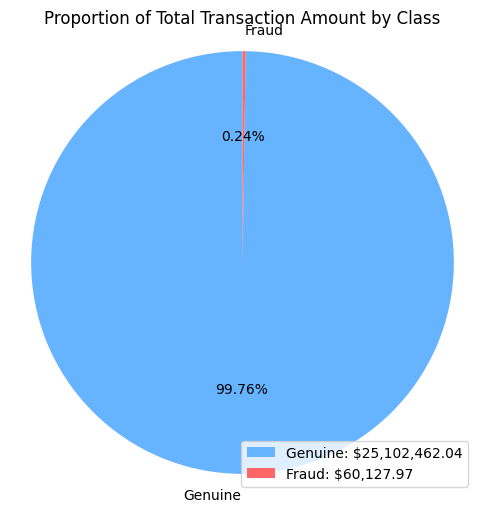

In [27]:
# Calculate total transaction amount by class
total_amount_by_class = crecard.groupby('Class')['Amount'].sum()

# Pie chart with legend showing total amount
plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(
    total_amount_by_class,
    labels=['Genuine', 'Fraud'],
    autopct='%1.2f%%',
    startangle=90,
    colors=['#66b3ff', '#ff6666']
)
plt.title('Proportion of Total Transaction Amount by Class')
plt.axis('equal')

# Add legend with total amount
amount_labels = [
    f'Genuine: ${total_amount_by_class[0]:,.2f}',
    f'Fraud: ${total_amount_by_class[1]:,.2f}'
]
plt.legend(patches, amount_labels, loc='best')
plt.show()

In [28]:
# Lấy số lượng giao dịch vào lúc 2 giờ sáng (tức là từ 2:00:00 đến 2:59:59) cho từng ngày

# Mỗi ngày có 86400 giây, 2 giờ sáng là từ 7200 đến 10799 giây (2*3600 đến 2*3600+3599)
day1_mask = (crecard['Time'] >= 7200) & (crecard['Time'] < 10800)
day2_mask = (crecard['Time'] >= 86400 + 7200) & (crecard['Time'] < 86400 + 10800)

count_day1 = crecard[day1_mask].shape[0]
count_day2 = crecard[day2_mask].shape[0]

print(f"Số giao dịch lúc 2 giờ sáng ngày 1: {count_day1}")
print(f"Số giao dịch lúc 2 giờ sáng ngày 2: {count_day2}")

Số giao dịch lúc 2 giờ sáng ngày 1: 1576
Số giao dịch lúc 2 giờ sáng ngày 2: 1752


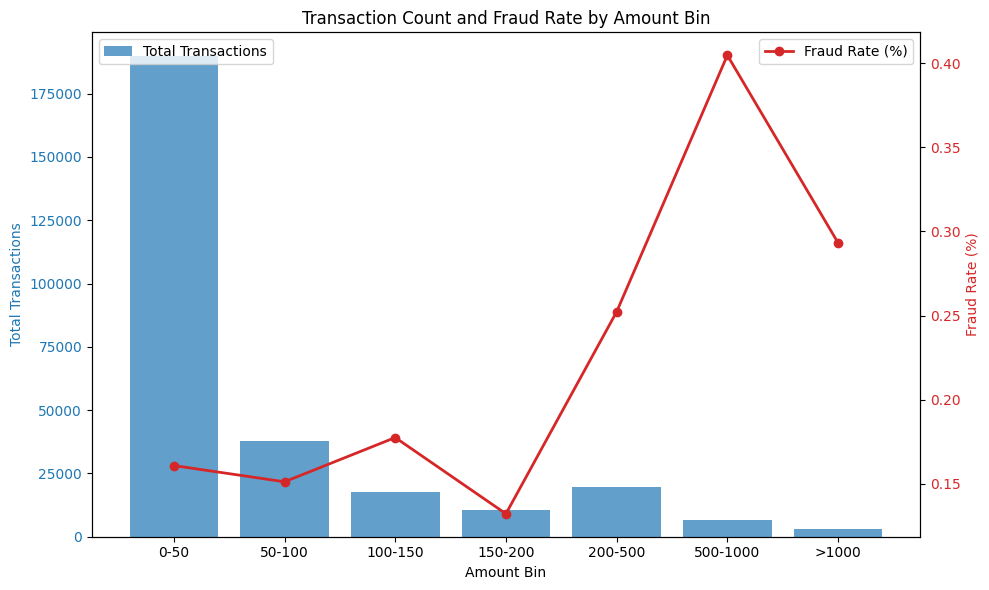

In [29]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot: Total transactions by amount bin
color = 'tab:blue'
ax1.bar(labels, count_by_bin, color=color, alpha=0.7, label='Total Transactions')
ax1.set_xlabel('Amount Bin')
ax1.set_ylabel('Total Transactions', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Line plot: Fraud rate by amount bin (percentage)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(labels, fraud_rate_by_bin * 100, color=color, marker='o', linewidth=2, label='Fraud Rate (%)')
ax2.set_ylabel('Fraud Rate (%)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('Transaction Count and Fraud Rate by Amount Bin')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [30]:
# Drop 'Amount_bin' column
crecard = crecard.drop(columns=['Amount_bin'])

# Encode 'Time' as cyclical features (sin, cos)
seconds_in_day = 86400
crecard['Time_sin'] = np.sin(2 * np.pi * crecard['Time'] / seconds_in_day)
crecard['Time_cos'] = np.cos(2 * np.pi * crecard['Time'] / seconds_in_day)

# Drop original 'Time' column
crecard = crecard.drop(columns=['Time'])

crecard.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_sin,Time_cos
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000,1.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000,1.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000073,1.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000073,1.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000145,1.0


In [31]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(crecard, test_size=0.3, stratify=crecard['Class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Class'], random_state=42)

print(f"Số lượng mẫu train: {len(train_df)}")
print(f"Số lượng mẫu validation: {len(val_df)}")
print(f"Số lượng mẫu test: {len(test_df)}")

Số lượng mẫu train: 199364
Số lượng mẫu validation: 42721
Số lượng mẫu test: 42722


In [34]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold

# Chuẩn bị dữ liệu
X = train_df.drop(['Class'], axis=1)
y = train_df['Class']
X_val = val_df.drop(['Class'], axis=1)
y_val = val_df['Class']

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=66,
    n_jobs=-1,
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X, y)
xgb_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
xgb_auprc = average_precision_score(y_val, xgb_pred_proba)
print(f'XGBoost AUPRC: {xgb_auprc:.4f}')

# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    class_weight='balanced',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=312,
    n_jobs=-1
)
lgb_model.fit(X, y)
lgb_pred_proba = lgb_model.predict_proba(X_val)[:, 1]
lgb_auprc = average_precision_score(y_val, lgb_pred_proba)
print(f'LightGBM AUPRC: {lgb_auprc:.4f}')

c:\Users\ducho\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:51:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost AUPRC: 0.8266
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM AUPRC: 0.8448


In [ ]:
import optuna
from sklearn.metrics import average_precision_score
import time

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X, y)
    pred_proba = model.predict_proba(X_val)[:, 1]
    score = average_precision_score(y_val, pred_proba)
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=300)  # 5 phút = 300 giây

print("Best trial:")
print(study.best_trial)
print("Best params:", study.best_params)
print("Best AUPRC:", study.best_value)